#TFM Néstor Félix



Este notebook usará la biblioteca UrbanPy del BID (un proyecto open source para automatizar la extracción, medición y visualización de métricas de accesibilidad urbana). La librería se basa en información abierta a partir del proyecto de [OpenStreetMap](https://www.openstreetmap.org/). OpenStreetMap (OSM) es un servicio de mapas online que publica información contribuida en forma libre. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)


import sys
sys.path.append('..')

import urbanpy as up
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import plotly.express as px
import osmnx as ox

## Descarga de datos urbanos



Definimos en primer lugar la ciudad o país que queremos analizar. En este caso Argentina

In [2]:
arg = 'Argentina'
arg = up.download.nominatim_osm(arg)

Text(0.5, 1.0, '                                            geometry  place_id  osm_type  \\\n0  MULTIPOLYGON (((-73.56054 -49.94247, -73.56048...  16700470  relation   \n\n   osm_id  place_rank  category            type  importance addresstype  \\\n0  286393           4  boundary  administrative    0.810104     country   \n\n        name display_name  \n0  Argentina    Argentina  ')

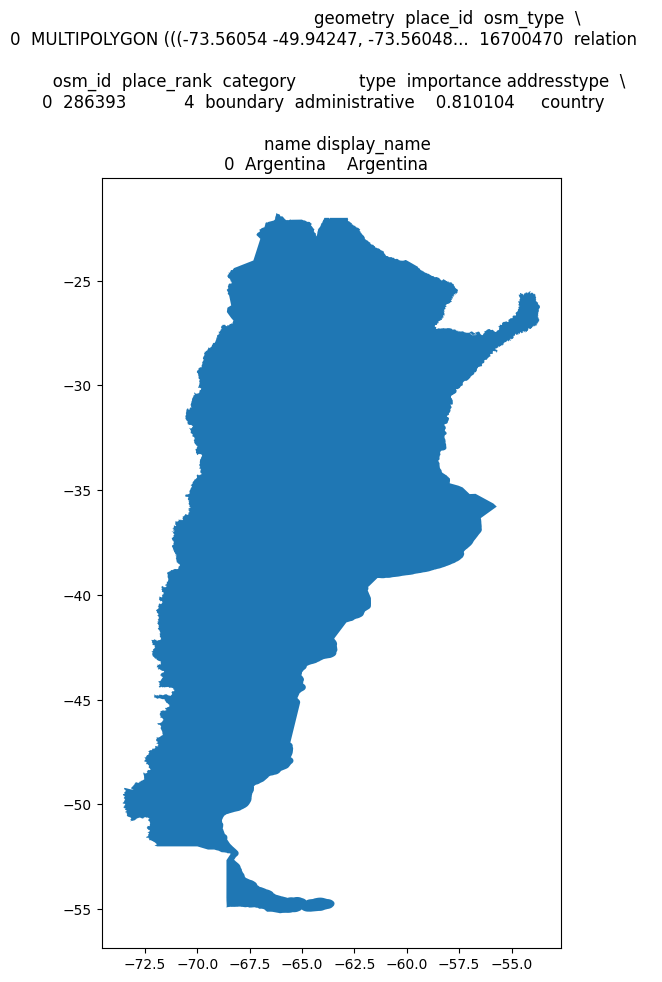

In [3]:
arg.plot()
plt.title(arg)

Para aplicar algoritmos y visualizar datos espaciales variados definimos una unidad espacial uniforme con el paquete [Uber H3](https://eng.uber.com/h3/) para dividir la el mapa en hexágonos uniformes.

In [4]:
h3_resolution = 5

hex_arg = up.geom.gen_hexagons(h3_resolution, city=arg)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U26')) -> None

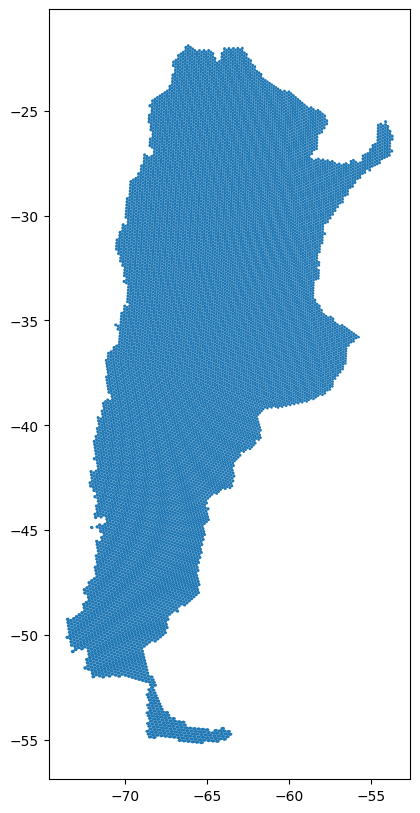

In [5]:
hex_arg.plot()
plt.title(arg + ". Celdas H3 de resolución " + str(h3_resolution))

Podemos utilizar la función *head* para ver los primeros registros.


In [6]:
hex_arg.head()

hex                                           geometry
0  85a96513fffffff  POLYGON ((-59.11160 -29.68580, -59.06164 -29.6...
1  85b22cbbfffffff  POLYGON ((-67.37591 -24.98490, -67.42914 -25.0...
2  85c32c33fffffff  POLYGON ((-66.19492 -42.23579, -66.16776 -42.1...
3  85cf8397fffffff  POLYGON ((-69.57310 -47.61810, -69.53571 -47.5...
4  85b2658bfffffff  POLYGON ((-61.89822 -26.74460, -61.94714 -26.8...

La función *shape* nos permite ver el tamaño del dataset.


In [7]:
hex_arg.shape

(14202, 2)

En este caso, Argentina está dividida en 14202 hexágonos

## Descarga de datos de población

La información de datos de población se descarga a nivel país con la función *hdx_fb_population* disponible en la librería UrbanPy.
En esta función se define en primer lugar el país, y luego el tipo de población: *full* (refiere a toda la población), *children* (refiere a niños y niñas), *youth* (refiere a jóvenes) y *elderly* (refiere a la población adulta).
La función accede a los [estimados demográficos de alta resolución que ha creado Facebook](https://dataforgood.facebook.com/dfg/docs/high-resolution-population-density-maps-demographic-estimates-documentation), con datos precisos sobre la densidad de población en cualquier parte del mundo.

 <font color="grey"> [English] The population data information is downloaded at the country level with the function *hdx_fb_population* available in the UrbanPy library.
In this function the country is defined first, then the type of population: *full* (refers to the entire population), *children* (refers to children), *youth* (refers to youth) and *elderly* (refers to the adult population).
The function accesses the [high-resolution demographic estimates created by Facebook](https://dataforgood.facebook.com/dfg/docs/high-resolution-population-density-maps-demographic-estimates-documentation), with accurate data on population density anywhere in the world.

  <font color="grey"> [Portugues] A informação de dados populacionais é descarregada a nível de país com a função *hdx_fb_population* disponível na biblioteca UrbanPy.
Nesta função o país é definido primeiro, e depois o tipo de população: *full* (refere-se a toda a população), *children* (refere-se a crianças), *youth* (refere-se a jovens) e *elderly* (refere-se à população adulta).
A função acede às [estimativas demográficas de alta resolução criadas pelo Facebook](https://dataforgood.facebook.com/dfg/docs/high-resolution-population-density-maps-demographic-estimates-documentation), com dados precisos sobre a densidade populacional em qualquer parte do mundo.

In [14]:
pop_arg = up.download.hdx_dataset('6cf49080-1226-4eda-8700-a0093cbdfe4d/resource/5737d87f-e17f-4c82-b1bd-d589ed631318/download/arg_general_2020_csv.zip')

Una vez que tenemos los datos de población, utilizamos la función head para ver los primeros registros.  

 <font color="grey"> [English] Once we have the population data, we use the head function to view the first records.

  <font color="grey"> [Portugues] Assim que tivermos os dados da população, utilizamos a função da cabeça para visualizar os primeiros registos.

In [15]:
pop_arg.head()

longitude   latitude  arg_general_2020
0 -68.792917 -20.999861         15.589419
1 -65.742361 -20.999861          9.786258
2 -65.615694 -20.999861          9.786258
3 -64.682639 -20.999861          3.107346
4 -63.332361 -20.999861          2.909961

Como podemos observar, contamos con la población de 2015, 2020 y la latitud/longitud. Los datos corresponden a toda la Argentina. Vamos primero a filtrar por la zona de interés.

 <font color="grey"> [English] As we can see, we have the population of 2015, 2020 and latitude/longitude. The data corresponds to all of Argentina. Let's first filter by the area of interest.  

  <font color="grey"> [Portugues] Como podemos ver, temos a população de 2015, 2020 e latitude/longitude. Os dados correspondem a toda a Argentina. Vamos primeiro filtrar pela área de interesse.

In [16]:
pop_arg = up.geom.filter_population(pop_arg, arg)

Al aplicar la función *filter_population*, filtramos la población dentro del bounding box que contiene a nuestra ciudad.
El bounding box (o caja de coordenadas) refiere a las coordenadas de un rectángulo que abarque la zona de interés, es decir los valores máximos y mínimos de latitud y longitud.

 <font color="grey"> [English] By applying the *filter_population* function, we filter the population within the bounding box containing our city.
The bounding box refers to the coordinates of a rectangle that encompasses the area of interest, i.e. the maximum and minimum values of latitude and longitude.  

  <font color="grey"> [Portugues] Aplicando a função *filter_population*, filtramos a população dentro da caixa delimitadora que contém a nossa cidade.
A caixa de delimitação refere-se às coordenadas de um rectângulo que abrange a área de interesse, ou seja, os valores máximo e mínimo de latitude e longitude.

Ejemplo de Bounding Box:   
El polígono rojo corresponde a la geometría de la ciudad de Buenos Aires. La línea punteada azul muestra la caja de coordenadas (bounding box).

 <font color="grey"> [English] Example of Bounding Box:   
The red polygon corresponds to the geometry of the city of Buenos Aires. The blue dotted line shows the bounding box.

  <font color="grey"> [Portugues] Exemplo de Bounding Box:   
O polígono vermelho corresponde à geometria da cidade de Buenos Aires. A linha azul pontilhada mostra a caixa de encadernação (bounding box).


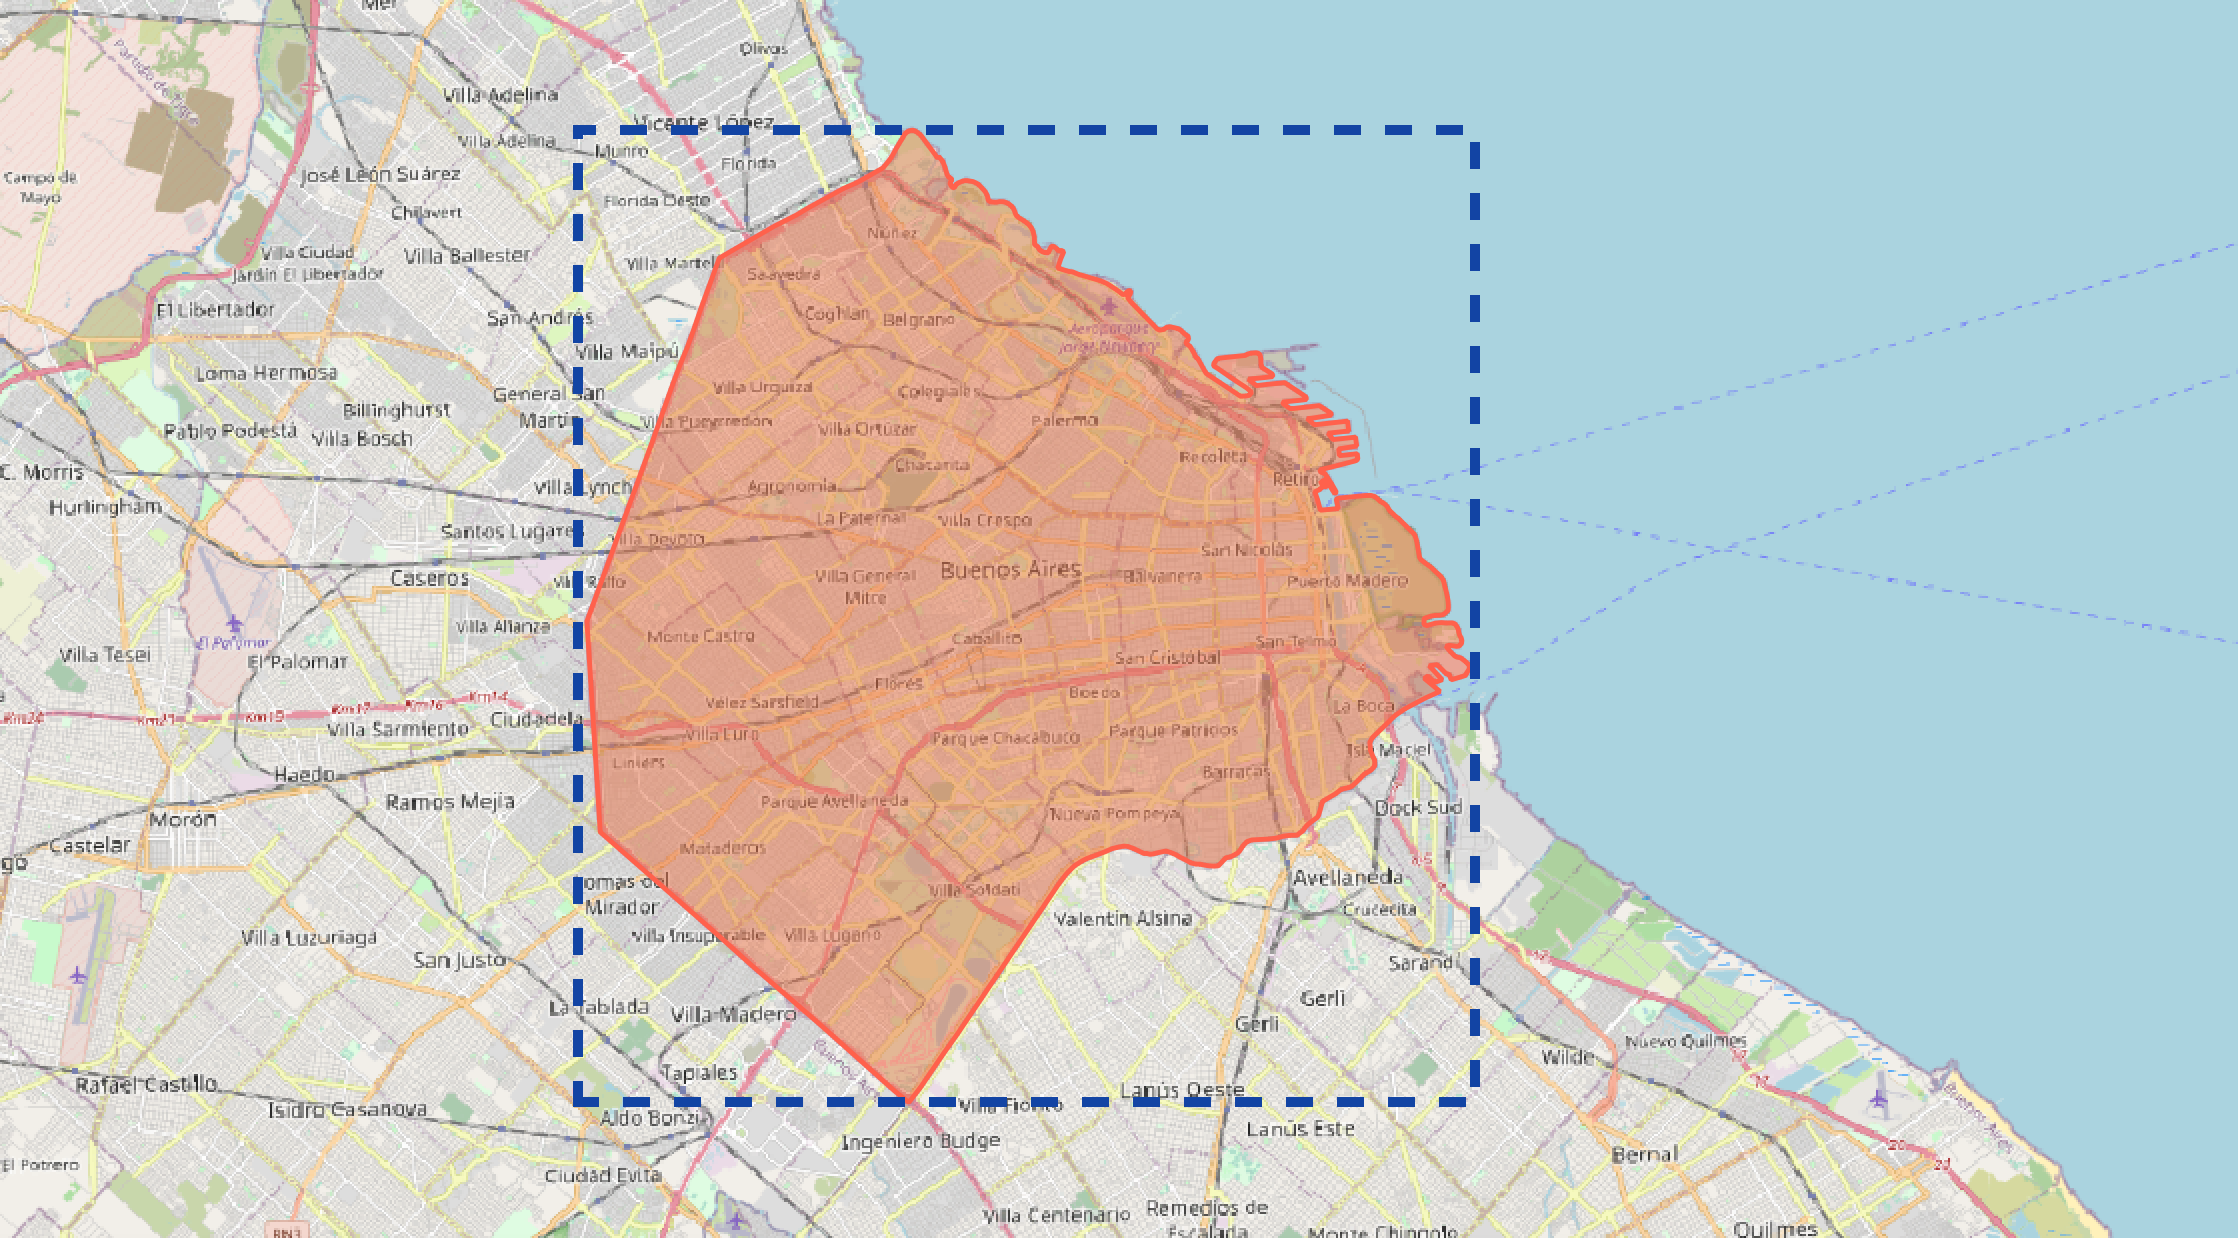

Veamos el resultado del filtro:

 <font color="grey"> [English] Let's see the result of the filter:  

  <font color="grey"> [Portugues] Vamos ver o resultado do filtro:

<Axes: >

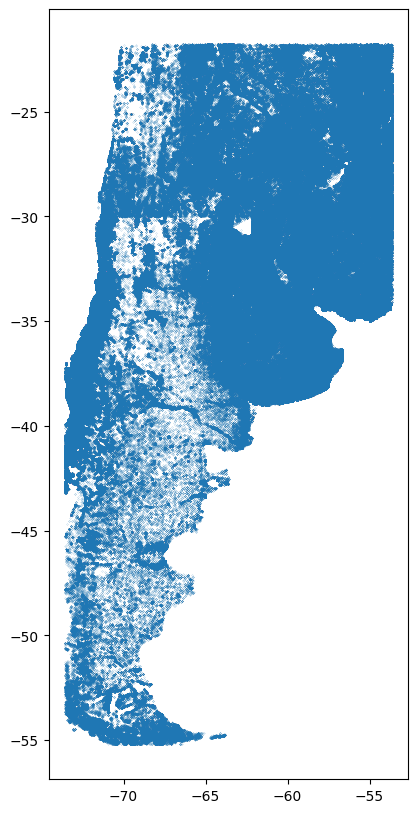

In [17]:
pop_arg.plot(markersize = 0.01)

Efectivamente, los datos se extienden por fuera del límite de nuestra ciudad.

 <font color="grey"> [English] Indeed, the data extends beyond our city limits.

  <font color="grey"> [Portugues] De facto, os dados estendem-se para além dos limites da nossa cidade.

Ahora que tenemos los puntos de población, y los hexágonos, vamos a calcular la población por hexagono. Para eso, se utiliza la función *merge_shape_hex*

 <font color="grey"> [English] Now that we have the population points, and the hexagons, let's calculate the population per hexagon. For that, we use the function *merge_shape_hex*.

  <font color="grey"> [Portugues] Agora que temos os pontos de população, e os hexágonos, vamos calcular a população por hexágono. Para isso, usamos a função *merge_shape_hex*.

In [21]:
hex_arg = up.geom.merge_shape_hex(hex_arg, pop_arg, agg={'arg_general_2020':'sum'})

In [22]:
hex_arg.head()

hex                                           geometry  \
0  85ce9c33fffffff  POLYGON ((-70.44863 -39.19590, -70.41530 -39.1...   
1  85c22d6ffffffff  POLYGON ((-59.95993 -37.10441, -60.00912 -37.1...   
2  85c3588ffffffff  POLYGON ((-61.70758 -36.10284, -61.75821 -36.1...   
3  85c2eb33fffffff  POLYGON ((-60.55988 -32.64604, -60.60870 -32.7...   
4  85b20a37fffffff  POLYGON ((-69.62816 -29.55959, -69.68399 -29.6...   

   arg_general_2020  
0         51.795878  
1        465.088830  
2        228.736684  
3         18.615925  
4         50.186916

Veamos los datos en un mapa

 <font color="grey"> [English] Let's see the data on a map.

  <font color="grey"> [Portugues] Vejamos os dados num mapa.

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U16')) -> None

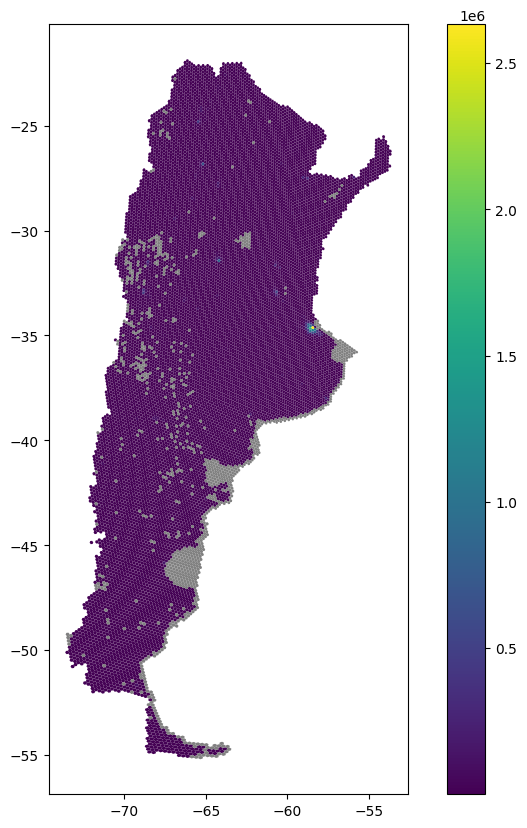

In [24]:
hex_arg.plot('arg_general_2020', legend=True, missing_kwds={'color':'grey'})
plt.title(arg + ". Población 2020")

Vamos a armar un mapa interactivo para visualizar la información. Para eso, podemos utilizar la función *choropleth_map*. Esta función se basa en *choropleth_mapbox* de la librería *plotly*. [Aquí](https://plotly.com/python/mapbox-county-choropleth/) se pueden ver más parámetros para configurar.


 <font color="grey"> [English] We are going to build an interactive map to visualize the information. For that, we can use the *choropleth_map* function. This function is based on *choropleth_mapbox* from the *plotly* library. [Here](https://plotly.com/python/mapbox-county-choropleth/) you can see more parameters to configure.

  <font color="grey"> [Portugues] Vamos construir um mapa interactivo para visualizar a informação. Para isso, podemos utilizar a função *choropleth_map*. Esta função é baseada na *choropleth_mapbox* da biblioteca *plotly*. [Aqui](https://plotly.com/python/mapbox-county-choropleth/) é possível ver mais parâmetros a configurar.

In [26]:
fig = up.plotting.choropleth_map(hex_arg, 'arg_general_2020', title=arg + '. Población estimada - 2020',
                                 zoom = 10, color_continuous_scale="Viridis",
                                 opacity=0.8,
                                 labels={'arg_general_2020':'Población 2020'}
                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U27')) -> None

### Mujeres en edad reproductiva (15-49 años)

 <font color="grey"> [English] Women of reproductive age (15-49 years)

  <font color="grey"> [Portugues] Mulheres em idade reprodutiva (15-49 anos)


Este grupo de población es de suma relevancia para políticas públicas orientadas a salud. Para acceder a esos datos, vamos a utilizar otra función de UrbanPy realizando una búsqueda manual en el [repositorio online](https://data.humdata.org/organization/facebook) de los datos, y copiando el identificador de dataset.

Por ejemplo, para la población de mujeres en edad reproductiva, encontramos:


 <font color="grey"> [English] This population group is highly relevant for health-oriented public policies. To access these data, we will use another function of UrbanPy by performing a manual search in the [online repository](https://data.humdata.org/organization/facebook) of the data, and copying the dataset identifier.
For example, for the population of women of reproductive age, we find:

  <font color="grey"> [Portugues] Este grupo populacional é altamente relevante para as políticas públicas orientadas para a saúde. Para aceder a estes dados, utilizaremos outra função da UrbanPy, pesquisando manualmente o [repositório em linha](https://data.humdata.org/organization/facebook) para os dados, e copiando o identificador do conjunto de dados.
Por exemplo, para a população de mulheres em idade reprodutiva, encontramos:

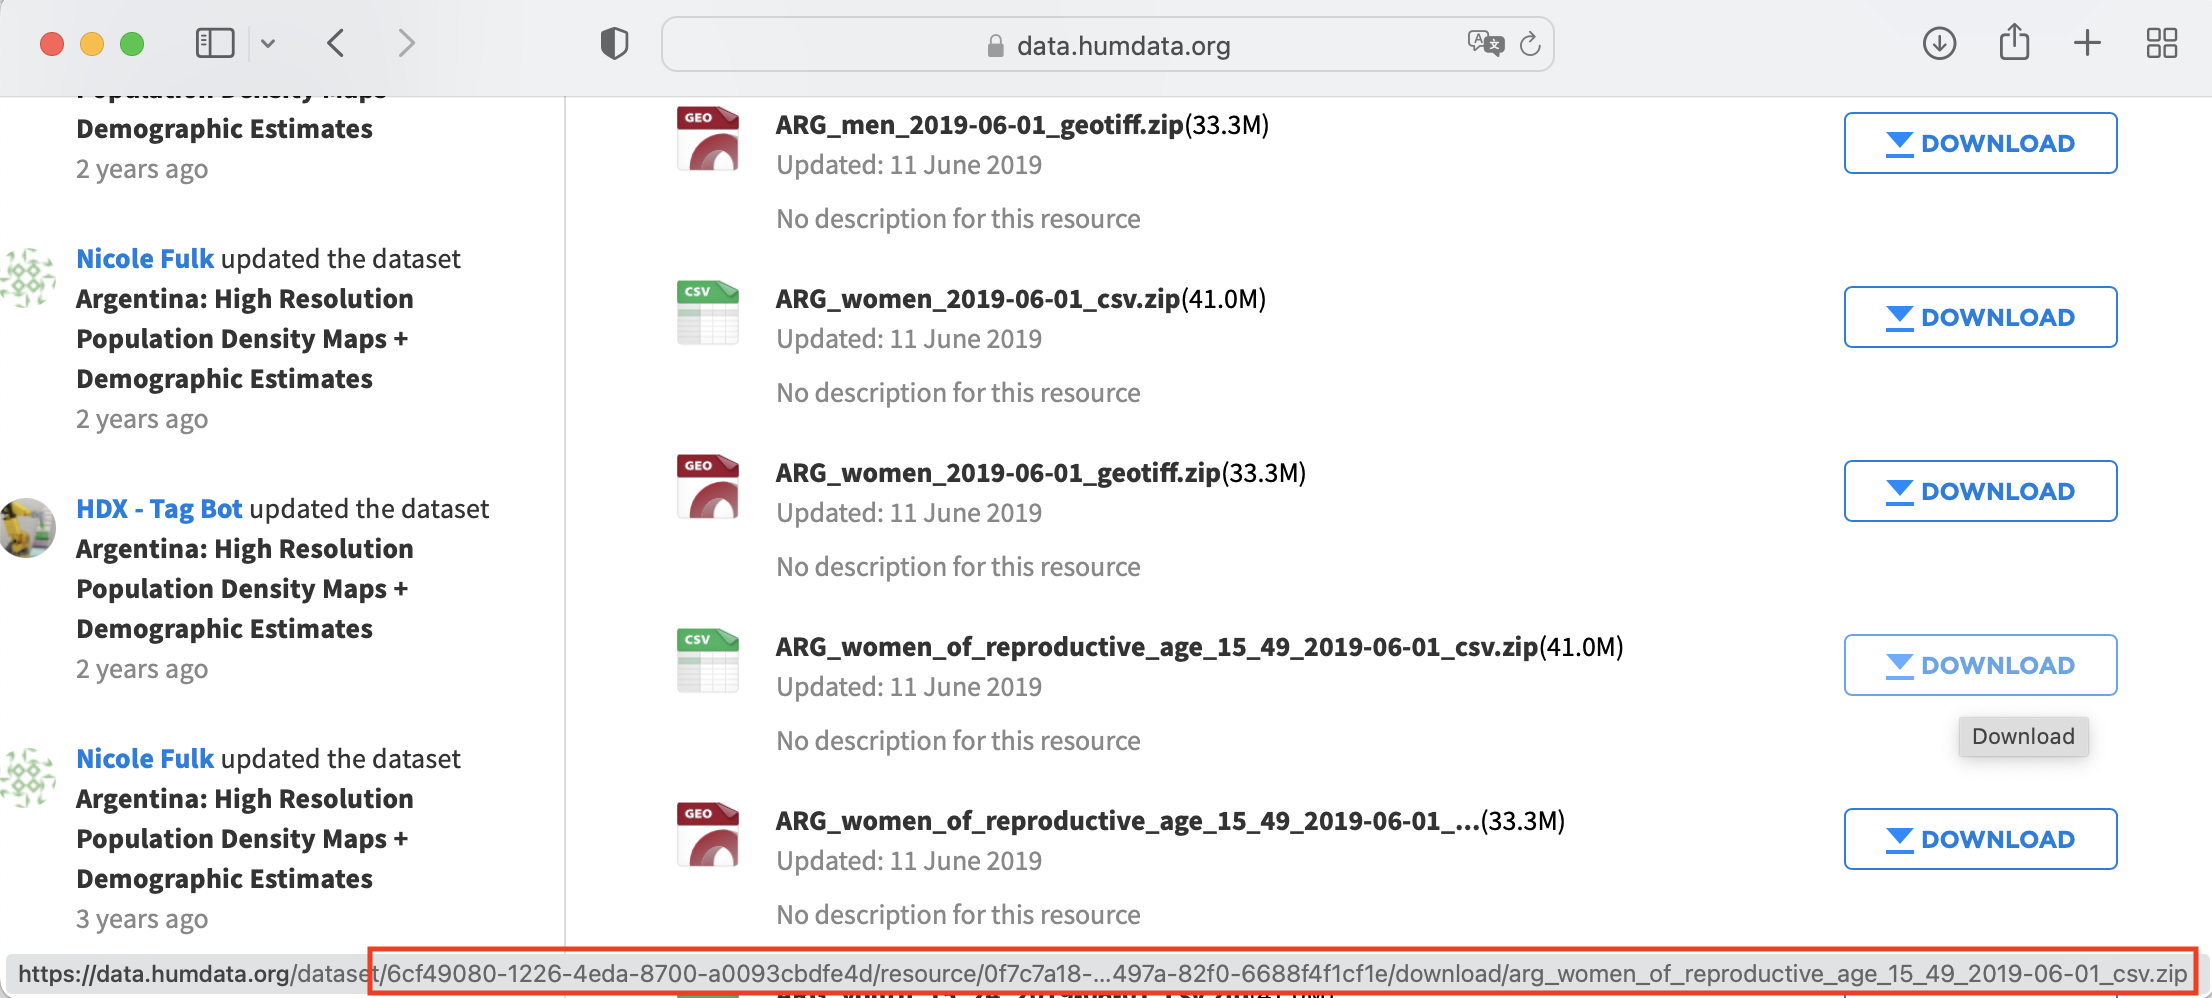

Ya provistos con el identificador exacto, podemos generar la siguiente búsqueda a partir de la siguiente función de UrbanPy `up.download.hdx_dataset()`:   

 <font color="grey"> [English] Now that we have the exact identifier, we can generate the following search from the following UrbanPy function `up.download.hdx_dataset()`:

  <font color="grey"> [Portugues] Já fornecido com o identificador exacto, podemos gerar a seguinte pesquisa a partir da seguinte função UrbanPy `up.download.hdx_dataset()`:

In [ ]:
pop_fem_rep = up.download.hdx_dataset('6cf49080-1226-4eda-8700-a0093cbdfe4d/resource/0f7c7a18-2db4-497a-82f0-6688f4f1cf1e/download/arg_women_of_reproductive_age_15_49_2019-06-01_csv.zip')

Veamos los datos que descargamos que corresponden al año 2019.

 <font color="grey"> [English] Let's take a look at the data we downloaded that correspond to 2019.

  <font color="grey"> [Portugues] Vamos dar uma vista de olhos aos dados que descarregámos para 2019.

In [ ]:
pop_fem_rep.head()

latitude  longitude  population
0 -30.359861 -66.312083    0.816893
1 -30.419028 -66.345139    0.816893
2 -30.352083 -66.318194    0.816893
3 -30.365139 -66.311250    0.816893
4 -30.355417 -66.315972    0.816893

Vamos a filtrar los datos que corresponden solo a la Ciudad Autónoma de Buenos Aires.

 <font color="grey"> [English] We will filter the data corresponding only to the city of Buenos Aires.

  <font color="grey"> [Portugues] Filtraremos os dados correspondentes apenas à cidade de Buenos Aires.

In [ ]:
pop_ba_fem_rep = up.geom.filter_population(pop_fem_rep, ba)

Nuevamente, vamos a utilizar funciones de UrbanPy para estimar la cantidad de mujeres en edad reproductiva en nuestra grilla hexagonal.

 <font color="grey"> [English] Again, we will use UrbanPy functions to estimate the number of women of reproductive age in our hexagonal grid.

  <font color="grey"> [Portugues] Mais uma vez, utilizaremos as funções UrbanPy para estimar o número de mulheres em idade reprodutiva na nossa grelha hexagonal.

In [ ]:
hex_ba = up.geom.merge_shape_hex(hex_ba, pop_ba_fem_rep, agg={'population':'sum'})

Veamos los resultados

 <font color="grey"> [English] Let's see the results

  <font color="grey"> [Portugues] Vamos ver os resultados

In [ ]:
hex_ba.head()

hex                                           geometry  \
0  88c2e3129bfffff  POLYGON ((-58.52916 -34.61814, -58.52516 -34.6...   
1  88c2e3124bfffff  POLYGON ((-58.47197 -34.68774, -58.46797 -34.6...   
2  88c2e38d21fffff  POLYGON ((-58.50269 -34.66442, -58.49869 -34.6...   
3  88c2e31293fffff  POLYGON ((-58.52591 -34.61242, -58.52192 -34.6...   
4  88c2e31253fffff  POLYGON ((-58.48845 -34.67032, -58.48446 -34.6...   

   population_2020   population  
0      4079.975611   996.683275  
1      8180.263903  2153.935784  
2      4999.083280  1215.525704  
3      5866.716501  1431.719693  
4      7449.903227  1946.448088

Vamos a renombrar la variable *population* a fin de identificar mejor que se trata de mujeres en edad reproductiva.

 <font color="grey"> [English] We will rename the variable *population* in order to better identify that we are dealing with women of reproductive age.


  <font color="grey"> [Portugues] Daremos um novo nome à variável *population* a fim de melhor identificar que se trata de mulheres em idade reprodutiva.


In [ ]:
hex_ba = hex_ba.rename(columns = {'population':'pop_fem_rep_2019'})

Verifiquemos que la columna fue renombrada.  

<font color="grey"> [English] Let's check that the column was renamed.  

<font color="grey"> [Portugues] Vamos verificar se a coluna foi renomeada.  


In [ ]:
hex_ba.head()

hex                                           geometry  \
0  88c2e3129bfffff  POLYGON ((-58.52916 -34.61814, -58.52516 -34.6...   
1  88c2e3124bfffff  POLYGON ((-58.47197 -34.68774, -58.46797 -34.6...   
2  88c2e38d21fffff  POLYGON ((-58.50269 -34.66442, -58.49869 -34.6...   
3  88c2e31293fffff  POLYGON ((-58.52591 -34.61242, -58.52192 -34.6...   
4  88c2e31253fffff  POLYGON ((-58.48845 -34.67032, -58.48446 -34.6...   

   population_2020  pop_fem_rep_2019  
0      4079.975611        996.683275  
1      8180.263903       2153.935784  
2      4999.083280       1215.525704  
3      5866.716501       1431.719693  
4      7449.903227       1946.448088

Veamos los resultados en un mapa.   

<font color="grey"> [English] Let's see the results on a map.   

<font color="grey"> [Portugues] Vejamos os resultados num mapa.   

In [ ]:
fig = up.plotting.choropleth_map(hex_ba, 'pop_fem_rep_2019', title=ciudad + '. Población estimada - 2019',
                                 zoom = 10, color_continuous_scale="Viridis",
                                 opacity=0.8,
                                 labels={'pop_fem_rep_2019':'Mujeres en edad reproductiva'}

                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()

Veamos los dos mapas juntos (población total en 2020 y población femenina en edad reproductiva en 2019).  

<font color="grey"> [English] Let's look at the two maps together (total population in 2020 and female population of reproductive age in 2019).  

<font color="grey"> [Portugues] Vejamos os dois mapas em conjunto (população total em 2020 e população feminina em idade reprodutiva em 2019).  

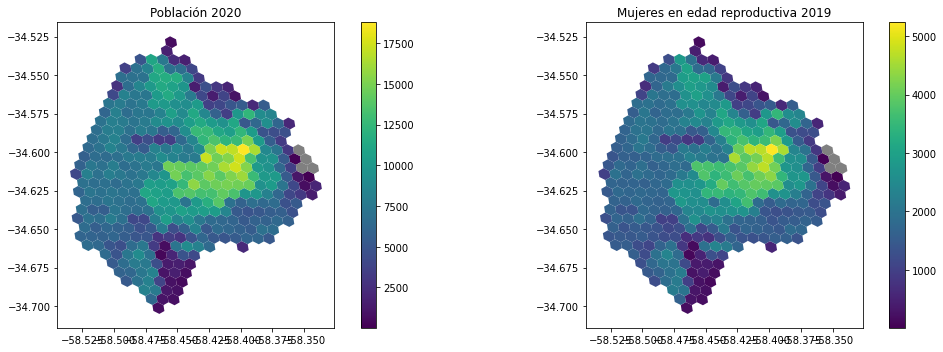

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

hex_ba.plot('population_2020', legend=True, missing_kwds={'color':'grey'}, ax = ax1)
hex_ba.plot('pop_fem_rep_2019', legend=True, missing_kwds={'color':'grey'}, ax = ax2)

ax1.title.set_text('Población 2020')
ax2.title.set_text('Mujeres en edad reproductiva 2019')

plt.tight_layout()

Observamos que los patrones en los gráficos son muy similares.

<font color="grey"> [English] We note that the patterns in the graphs are very similar.   

<font color="grey"> [Portugues] Observamos que os padrões nos gráficos são muito semelhantes.

## Accesibilidad urbana

### <font color="grey"> [English] Urban accessibility

### <font color="grey"> [Portugues] Acessibilidade urbana

Para evaluar accesibilidad urbana, es necesario primero definir accesibilidad a que lugar(es) de interés, para luego obtener los datos de esos puntos de interés.  
Para obtener datos georeferenciados de puntos de interés realizaremos consultas a [Overpass](https://overpass-api.de/), una interfaz que permite extraer información de la base de datos global de OpenStreetMap. En [este wiki](https://wiki.openstreetmap.org/wiki/Map_features) se pueden consultar los datos disponibles en OSM.

Overpass requiere que se especifique un *bounding box*. Para obtenerlo, se puede usar la propiedad *total_bounds*, que devuelve un array con los valores.

<font color="grey"> [English] To evaluate urban accessibility, it is necessary to first define accessibility to which location(s) of interest, and then obtain the data for those points of interest.  
To obtain georeferenced data of points of interest we will query [Overpass](https://overpass-api.de/), an interface that allows to extract information from the global OpenStreetMap database. In [this wiki](https://wiki.openstreetmap.org/wiki/Map_features) you can query the data available in OSM.
Overpass requires that a *bounding box* be specified. To obtain it, you can use the *total_bounds* property, which returns an array with the values.


<font color="grey"> [Portugues] A fim de avaliar a acessibilidade urbana, é necessário primeiro definir a acessibilidade a que localização(ões) de interesse, e depois obter os dados para esses pontos de interesse.  
Para obter dados geo-referenciados de pontos de interesse iremos consultar [Overpass](https://overpass-api.de/), uma interface que permite extrair informação da base de dados global OpenStreetMap. Os dados disponíveis no OSM podem ser consultados em [este wiki](https://wiki.openstreetmap.org/wiki/Map_features).
O viaduto requer a especificação de uma caixa com *bounding box*. Para o obter, pode usar a propriedade *total_bounds*, que devolve um conjunto de valores.

In [ ]:
ba.total_bounds

array([-58.5314494, -34.705637 , -58.3351423, -34.5265535])

En este ejemplo, nos interesa evaluar la accesibilidad a establecimientos de salud. Estos servicios son esenciales para garantizar la calidad de vida de la ciudadanía.

<font color="grey"> [English] In this example, we are interested in evaluating accessibility to health facilities. These services are essential to ensure the quality of life of citizens.    

<font color="grey"> [Portugues] Neste exemplo, estamos interessados em avaliar a acessibilidade às instalações de saúde. Estes serviços são essenciais para garantir a qualidade de vida dos cidadãos.

In [ ]:
es = up.download.overpass_pois(bounds=ba.total_bounds, facilities='health')  # {'food', 'health', 'education', 'finance'}

Nuevamente, utilizamos la función *head* para ver los primeros resultados.

<font color="grey"> [English] Again, we use the *head* function to see the first results.   

<font color="grey"> [Portugues] Mais uma vez, utilizamos a função *head* para ver os primeiros resultados.

In [ ]:
es.head()

type         id        lat        lon  \
0  node  440909040 -34.633092 -58.521902   
1  node  474553860 -34.605004 -58.379509   
2  node  475032869 -34.602333 -58.379779   
3  node  477543967 -34.628847 -58.525377   
4  node  479156124 -34.599440 -58.371117   

                                                tags  \
0  {'amenity': 'pharmacy', 'healthcare': 'pharmacy'}   
1  {'amenity': 'pharmacy', 'brand': 'Farmacity', ...   
2  {'amenity': 'pharmacy', 'brand': 'Farmacity', ...   
3  {'amenity': 'pharmacy', 'healthcare': 'pharmac...   
4  {'amenity': 'pharmacy', 'brand': 'Farmacity', ...   

                      geometry  poi_type  
0  POINT (-58.52190 -34.63309)  pharmacy  
1  POINT (-58.37951 -34.60500)  pharmacy  
2  POINT (-58.37978 -34.60233)  pharmacy  
3  POINT (-58.52538 -34.62885)  pharmacy  
4  POINT (-58.37112 -34.59944)  pharmacy

Podemos ver diferentes tipos de amenities relacionados con establecimiento de salud. Veamos cuales son.

<font color="grey"> [English] We can see different types of amenities related to health facilities. Let's see what they are.   

<font color="grey"> [Portugues] Podemos ver diferentes tipos de amenidades relacionadas com as instalações de saúde. Vamos ver o que são.

In [ ]:
es.poi_type.value_counts()

pharmacy    769
clinic      190
dentist     104
doctors      62
hospital     33
Name: poi_type, dtype: int64

Veamos los geometrías en un mapa.

<font color="grey"> [English] Let's see the geometries on a map.  

<font color="grey"> [Portugues] Vejamos as geometrias num mapa.

Text(0.5, 1.0, 'Ciudad de Buenos Aires, Argentina. Puntos de interés OSM, categoría salud')

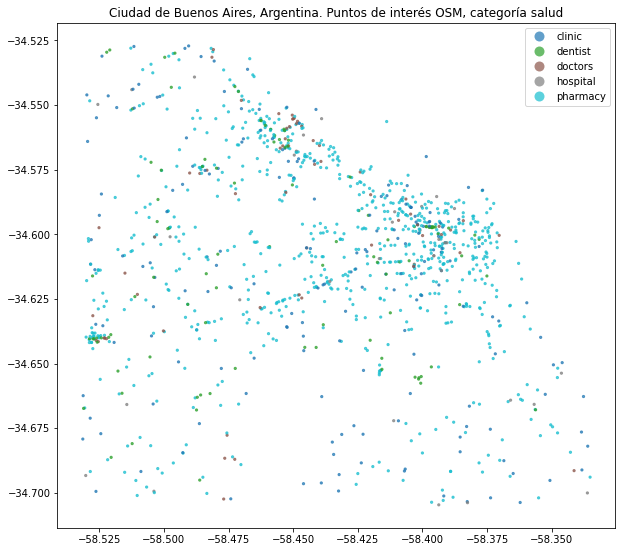

In [ ]:
es.plot('poi_type', markersize = 5, alpha = 0.7, legend=True)
plt.title(ciudad + ". Puntos de interés OSM, categoría salud")

### Acceso a hospitales

<font color="grey"> [English] Access to hospitals

<font color="grey"> [Portugues] Acesso aos hospitais

Primero vamos a evaluar la accesibilidad a hospitales en la Ciudad Autónoma de Buenos Aires. Para eso vamos a filtrar los datos descargados por el tipo 'hospital'.

<font color="grey"> [English] First we are going to evaluate the accessibility of hospitals in the Ciudad Autónoma de Buenos Aires. To do so, we will filter the downloaded data by type 'hospital'.

<font color="grey"> [Portugues] Primeiro vamos avaliar a acessibilidade dos hospitais da Ciudad Autónoma de Buenos Aires. Para tal, filtraremos os dados descarregados pelo tipo 'hospital'.

In [ ]:
hospitales = es[es['poi_type'] == 'hospital' ]

Visualicemos solo los hospitales.

<font color="grey"> [English] Let's visualize only hospitals.

<font color="grey"> [Portugues] Vamos visualizar apenas hospitais.

<AxesSubplot:>

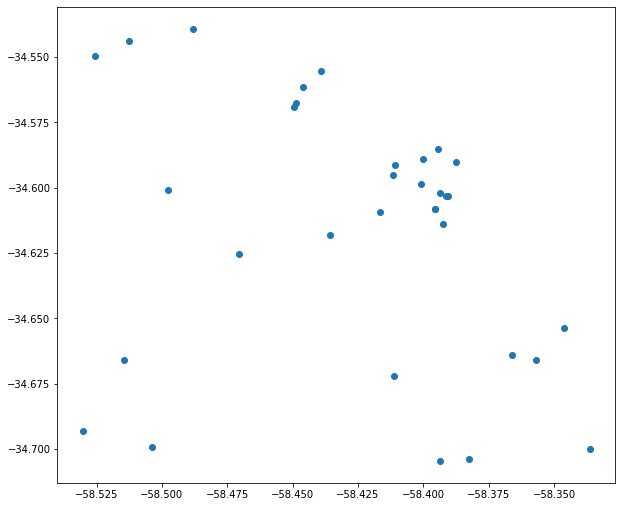

In [ ]:
hospitales.plot()

Ahora que tenemos la ubicación de los hospitales, calcularemos la distancia al hospital más cercano desde el centroide de los hexagonos.
Primero, vamos a calcular los centroides.

<font color="grey"> [English] Now that we have the location of the hospitals, we will calculate the distance to the nearest hospital from the centroid of the hexagons.
First, let's calculate the centroids.

<font color="grey"> [Portugues] Agora que temos a localização dos hospitais, calcularemos a distância até ao hospital mais próximo a partir do centroide dos hexágonos.
Primeiro, vamos calcular os centroides.

In [ ]:
hex_ba['lat'] = hex_ba.geometry.centroid.y
hex_ba['lon'] = hex_ba.geometry.centroid.x

Dentro de la librería *UrbanPy*, podemos utilizar la función *nn_search* para localizar los vecinos más cercanos (nearest neighboor).  

<font color="grey"> [English] Within the *UrbanPy* library, we can use the *nn_search* function to locate nearest neighbors.

<font color="grey"> [Portugues] Dentro da biblioteca *UrbanPy*, podemos usar a função *nn_search* para localizar os vizinhos mais próximos (nearest neighboor).

In [ ]:
dist_up, ind_up = up.utils.nn_search(
    tree_features=hospitales[['lat', 'lon']].values, # Puntos de interes
    query_features=hex_ba[['lat', 'lon']].values, # Centroides de los hexagonos
    metric='haversine' # Metrica de distancia
)

Agregamos la variable 'hosp_cercano' que indica el índice del hospital más cercano para ese hexágono.

<font color="grey"> [English] We add the variable 'hosp_cercano' which indicates the index of the nearest hospital for that hexagon.

<font color="grey"> [Portugues] Acrescentamos a variável 'hosp_cercano' indicando o índice do hospital mais próximo para aquele hexágono.

In [ ]:
hex_ba['hosp_cercano'] = ind_up
hex_ba.head()

hex                                           geometry  \
0  88c2e3129bfffff  POLYGON ((-58.52916 -34.61814, -58.52516 -34.6...   
1  88c2e3124bfffff  POLYGON ((-58.47197 -34.68774, -58.46797 -34.6...   
2  88c2e38d21fffff  POLYGON ((-58.50269 -34.66442, -58.49869 -34.6...   
3  88c2e31293fffff  POLYGON ((-58.52591 -34.61242, -58.52192 -34.6...   
4  88c2e31253fffff  POLYGON ((-58.48845 -34.67032, -58.48446 -34.6...   

   population_2020  pop_fem_rep_2019        lat        lon  hosp_cercano  
0      4079.975611        996.683275 -34.614299 -58.529906             5  
1      8180.263903       2153.935784 -34.683897 -58.472716             3  
2      4999.083280       1215.525704 -34.660584 -58.503437            17  
3      5866.716501       1431.719693 -34.608580 -58.526662             5  
4      7449.903227       1946.448088 -34.666483 -58.489203            17

Vamos a iniciar el servidor de ruteo de OSM.   
 <font color="red"> *Esta función no se encuentra disponible en Google Colab. Para utilizarla de manera local, es necesario previamente instalar Docker.*

 <font color="grey"> [English] Let's start the OSM routing server.   
 <font color="darkgrey"> *This feature is not available in Google Colab. To use it locally, it is necessary to install Docker first.*

<font color="grey"> [Portugues] Vamos iniciar o servidor de encaminhamento do OSM.   
 <font color="darkgrey"> *Esta característica não está disponível no Google Colab. Para o utilizar localmente, é necessário instalar primeiro o Docker.*


```
up.routing.start_osrm_server('argentina', 'south-america', 'foot')



Aplicamos la función de ruteo a nuestro dataset.

<font color="grey"> [English] We apply the routing function to our dataset.

<font color="grey"> [Portugues] Aplicamos a função de encaminhamento ao nosso conjunto de dados.

```
distance_duration = hex_ba.apply(
    lambda row: up.routing.osrm_route(
        origin=row.geometry.centroid,
        destination = hospitales.iloc[row['hosp_cercano']]['geometry']
    ),
    result_type='expand',
    axis=1,
)
```

Corrimos previamente la función de manera local, y guardamos los resultados en un archivo de tipo csv.

<font color="grey"> [English] We previously ran the function locally, and saved the results in a csv file.

<font color="grey"> [Portugues] Anteriormente, executámos a função localmente, e guardámos os resultados num ficheiro csv.

```
distance_duration.to_csv("distance_duration.csv", index = False)
```

Subimos el csv a github para poder cargarlo en este Colab.  

<font color="grey"> [English] We upload the csv to github to be able to load it in this Colab.

<font color="grey"> [Portugues] Carregamos o csv para o github para que possamos carregá-lo para este Colab.   

In [ ]:
distance_duration = pd.read_csv("https://raw.githubusercontent.com/paulavidela/tutoriales/main/urbanpy/distance_duration.csv")

Veamos los resultados:


<font color="grey"> [English] Let's see the results:

<font color="grey"> [Portugues] Vamos ver os resultados:

In [ ]:
distance_duration.head()

0       1
0  3134.4  2280.6
1   937.9   689.0
2  2603.7  1876.5
3  4075.4  2972.4
4  1423.4  1042.5

El dataset resultante contiene 2 variables:  
0 corresponde a la distancia  
1 corresponde a la duración del recorrido  

Vamos a incorporar estas dos variables a nuestro dataset *hex_ba*.


<font color="grey"> [English] The resulting dataset contains 2 variables:  
0 corresponds to the distance  
1 corresponds to the duration of the trip  
Let's incorporate these two variables into our dataset *hex_ba*.

<font color="grey"> [Portugues] O conjunto de dados resultante contém 2 variáveis:  
0 corresponde à distância  
1 corresponde à duração da viagem  
Vamos incorporar estas duas variáveis no nosso conjunto de dados *hex_ba*.

In [ ]:
hex_ba['distancia_a_hosp'] =  distance_duration["0"] / 1000 # metros a km
hex_ba['duracion_a_hosp'] = distance_duration["1"] / 60 # segundos a minutos

Veamos los resultados:


<font color="grey"> [English] Let's see the results:

<font color="grey"> [Portugues] Vamos ver os resultados:

In [ ]:
hex_ba.head()

hex                                           geometry  \
0  88c2e3129bfffff  POLYGON ((-58.52916 -34.61814, -58.52516 -34.6...   
1  88c2e3124bfffff  POLYGON ((-58.47197 -34.68774, -58.46797 -34.6...   
2  88c2e38d21fffff  POLYGON ((-58.50269 -34.66442, -58.49869 -34.6...   
3  88c2e31293fffff  POLYGON ((-58.52591 -34.61242, -58.52192 -34.6...   
4  88c2e31253fffff  POLYGON ((-58.48845 -34.67032, -58.48446 -34.6...   

   population_2020  pop_fem_rep_2019        lat        lon  hosp_cercano  \
0      4079.975611        996.683275 -34.614299 -58.529906             5   
1      8180.263903       2153.935784 -34.683897 -58.472716             3   
2      4999.083280       1215.525704 -34.660584 -58.503437            17   
3      5866.716501       1431.719693 -34.608580 -58.526662             5   
4      7449.903227       1946.448088 -34.666483 -58.489203            17   

   distancia_a_hosp  duracion_a_hosp  
0            3.1344        38.010000  
1            0.9379        11.483333  
2            2.6037        31.275000  
3            4.0754        49.540000  
4            1.4234        17.375000

Vamos a realizar un mapa que muestre la duración de viajes hasta el hospital más cercano.

<font color="grey"> [English] Let's make a map showing the travel time to the nearest hospital.

<font color="grey"> [Portugues] Vamos fazer um mapa mostrando os tempos de viagem até ao hospital mais próximo.

También podemos levantar los hexágonos desde Github.

<font color="grey"> [English] We can also lift the hexagons from Github.

<font color="grey"> [Portugues] Também podemos levantar os hexágonos de Github.

In [ ]:
hex_ba = gpd.read_file("https://raw.githubusercontent.com/paulavidela/tutoriales/main/urbanpy/hex_ba_hospitales.json")

In [ ]:
fig = up.plotting.choropleth_map(hex_ba, 'duracion_a_hosp',
                                 title= ciudad + '. Duración de los recorridos a establecimientos de comida',
                                 zoom = 10, color_continuous_scale="Plasma_r",
                                 opacity=0.8,
                                 labels={'duracion_a_hosp':'Duracion (min)'}

                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()

### Isocronas

<font color="grey"> [English] Isochrones

<font color="grey"> [Portugues] Isochrones

En el punto anterior, evaluamos donde se ubica la demanda de hospitales en la Ciudad Autónoma de Buenos Aires. A continuación, vamos a evaluar la cobertura de la oferta de salud.  
Para entender accesibilidad a los hospitales de la ciudad, vamos a generar isocronas desde los distintos hospitales que cubran una distancia recorrida en 5min, 10min, 15min, 20min, 25mi y 30min a pie, es decir desde donde se puede acceder a los hospitales caminando.

<font color="grey"> [English] In the previous point, we evaluated where the demand for hospitals is located in the Autonomous City of Buenos Aires. Next, we are going to evaluate the coverage of the health supply.  
To understand accessibility to hospitals in the city, we will generate isochrones from the different hospitals covering a distance of 5min, 10min, 15min, 20min, 25mi and 30min on foot, i.e. from where hospitals can be reached on foot.

<font color="grey"> [Portugues] Na secção anterior, avaliámos onde a procura de hospitais está localizada na Cidade Autónoma de Buenos Aires. A seguir, vamos avaliar a cobertura da oferta de saúde.  
Para compreender a acessibilidade aos hospitais da cidade, iremos gerar isócrones a partir dos diferentes hospitais cobrindo uma distância de 5min, 10min, 15min, 20min, 25mi e 30min a pé, ou seja, de onde os hospitais podem ser alcançados a pé.


¿Qué son las isocronas? Una isócrona se define como "una línea dibujada en un mapa los puntos de conexión en que algo ocurre o llega a la misma hora" (Fuente: [Wikipedia](https://es.wikipedia.org/wiki/Mapa_isócrono)). Ejemplo de un mapa isocróno:

<font color="grey"> [English] What are isochrones? An isochron is defined as "a line drawn on a map connecting points where something occurs or arrives at the same time" (Source: [Wikipedia](https://es.wikipedia.org/wiki/Mapa_isócrono)). Example of an isochrone map:

<font color="grey"> [Portugues] O que são isocrones? Um isocrone é definido como "uma linha desenhada num mapa que liga pontos onde algo ocorre ou chega ao mesmo tempo" (Fonte: [Wikipedia](https://es.wikipedia.org/wiki/Mapa_isócrono)). Exemplo de um mapa isocrónico:

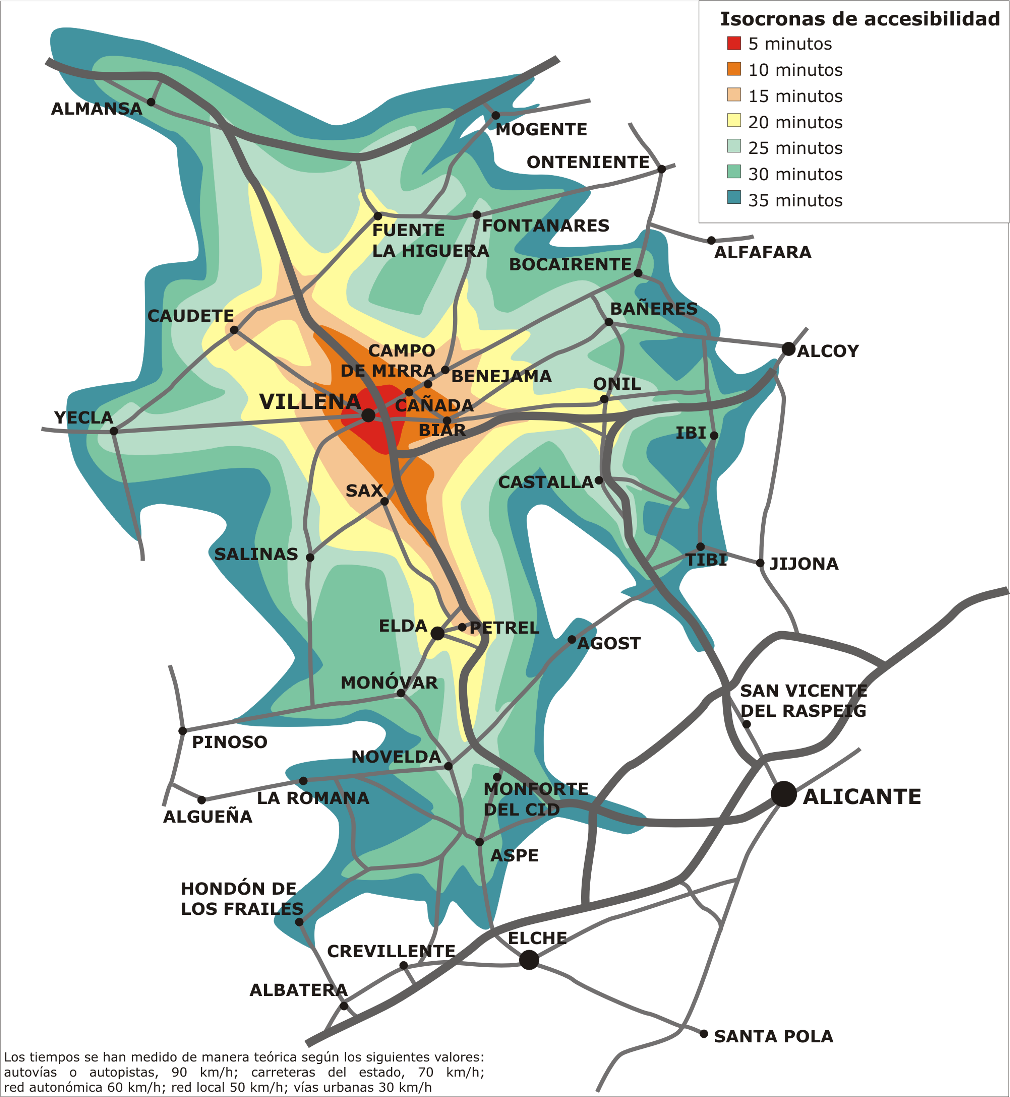

Volviendo a nuestro dataset de hospitales, recordemos el formato:

<font color="grey"> [English] Returning to our hospital dataset, let's recall the format:

<font color="grey"> [Portugues] Voltando ao nosso conjunto de dados hospitalares, vamos recordar o formato:

In [ ]:
hospitales.head()

type          id        lat        lon  \
64   node  1119491743 -34.601950 -58.393657   
90   node  1295516956 -34.589219 -58.400301   
94   node  1320979596 -34.595282 -58.411650   
103  node  1402832207 -34.699352 -58.503861   
106  node  1436034212 -34.609381 -58.416692   

                                                  tags  \
64   {'addr:city': 'Ciudad Autónoma de Buenos Aires...   
90   {'addr:full': 'Anchorena 1872', 'addr:housenum...   
94   {'amenity': 'hospital', 'healthcare': 'hospita...   
103  {'addr:city': 'Tapiales', 'addr:housenumber': ...   
106  {'addr:city': 'Ciudad Autónoma de Buenos Aires...   

                        geometry  poi_type  
64   POINT (-58.39366 -34.60195)  hospital  
90   POINT (-58.40030 -34.58922)  hospital  
94   POINT (-58.41165 -34.59528)  hospital  
103  POINT (-58.50386 -34.69935)  hospital  
106  POINT (-58.41669 -34.60938)  hospital

A partir de nuestro dataset de hospitales, vamos a generar una lista con las coordenadas.

<font color="grey"> [English] From our hospital dataset, we will generate a list of coordinates.

<font color="grey"> [Portugues] A partir do nosso conjunto de dados hospitalares, iremos gerar uma lista de coordenadas.

In [ ]:
hospitales_list = hospitales[['lon','lat']].values.tolist()

Vamos a utilizar la función `up.routing.isochrone_from_graph` para calcular las isocronas desde cada hospital. Para utilizar esta función, necesitamos como input los grafos de la ciudad (NetworkX or OSMnx graph). Vamos a utilizar otra función de UrbanPy para descargarlas: `up.routing.isochrone_from_graph`.

<font color="grey"> [English] We are going to use the `up.routing.isochrone_from_graph` function to calculate the isochrones from each hospital. To use this function, we need as input the city graphs (NetworkX or OSMnx graph). We will use another UrbanPy function to download them: `up.routing.isochrone_from_graph`.

<font color="grey"> [Portugues] Vamos utilizar a função `up.routing.isochrone_from_graph` para calcular os isocrones de cada hospital. Para utilizar esta função, precisamos dos gráficos da cidade (NetworkX or OSMnx graph) como entrada. Utilizaremos outra função UrbanPy para as descarregar: `up.routing.isochrone_from_graph`.

In [ ]:
ba_graph = up.download.osmnx_graph('polygon', 'walk', geom = ba.explode().geometry[0][0])

*Nota: la función* `ba.explode().geometry[0][0])` *nos permite obtener solamente la geometría (parámetro necesario para la función anterior)*


<font color="grey"> [English] *Note: the function* `ba.explode().geometry[0][0])` *allows us to obtain only the geometry (parameter needed for the previous function)*.

<font color="grey"> [Portugues] *Nota: a função* `ba.explode().geometry[0][0])` *permite-nos obter apenas a geometria (parâmetro necessário para a função anterior)*.

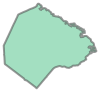

In [ ]:
ba.explode(index_parts=True).geometry[0][0]

Ahora si, ¡a calcular las isocronas!   
 <font color="red"> *Nuevamente, esta función no se encuentra disponible en Google Colab ya que es necesario tener activo el server de OSM mediante docker*


<font color="grey"> [English] Now yes, let's calculate the isochrones!   
 <font color="darkgrey"> *Once again, this function is not available in Google Colab since it is necessary to have the OSM server active through docker*.

<font color="grey"> [Portugues] Agora, vamos calcular os isocrones!   
 <font color="darkgrey"> *Novamente, esta função não está disponível no Google Colab uma vez que é necessário ter o servidor OSM activo através do docker*.


```
hospitales_isocronas = up.routing.isochrone_from_graph(
    graph=ba_graph,
    locations=hospitales_list,
    time_range=[5, 10, 15, 20, 25, 30],
    profile='walking'
)
```


Corrimos previamente la función de isocronas, y guardamos los resultados en un archivo de tipo *geojson*.

<font color="grey"> [English] We previously ran the isochrons' function locally, and saved the results in a *geojson* file.

<font color="grey"> [Portugues] Executámos previamente a função de isochrone, e guardámos os resultados num ficheiro do tipo *geojson*.



```
hospitales_isocronas.to_file('hospitales_isocronas.geojson', driver='GeoJSON')
```


Subimos el *geojson* a github para poder cargarlo en este Colab.  

<font color="grey"> [English] We upload the *geojson* to github to be able to load it in this Colab.

<font color="grey"> [Portugues] Carregamos o *geojson* para o github para que possamos carregá-lo para este Colab.   

In [ ]:
hospitales_isocronas = gpd.read_file('https://raw.githubusercontent.com/paulavidela/tutoriales/main/urbanpy/hospitales_isocronas.geojson')

Exploremos el dataset de isocronas.

<font color="grey"> [English] Vamos explorar o conjunto de dados do isochrone.

<font color="grey"> [Portugues] Vamos explorar o conjunto de dados do isochrone.

In [ ]:
hospitales_isocronas.head()

group_index  contour                                           geometry
0            0       30  POLYGON ((372328.890 -3832230.415, 372243.717 ...
1            0       25  POLYGON ((372281.265 -3831836.988, 370937.447 ...
2            0       20  POLYGON ((372275.174 -3831447.880, 371075.497 ...
3            0       15  POLYGON ((372259.599 -3830983.642, 371579.182 ...
4            0       10  POLYGON ((372243.303 -3830599.379, 371957.980 ...

Veamos su dimensión

<font color="grey"> [English] Let's see its dimension.

<font color="grey"> [Portugues] Vamos ver a sua dimensão.

In [ ]:
hospitales_isocronas.shape

(198, 3)

Ahora vamos a realizar un mapa para visualizar los resultados. Para eso, vamos a descargar un mapa base con la grilla de calles de la Ciudad Autónoma de Buenos Aires.

<font color="grey"> [English] Now we are going to make a map to visualize the results. For that, we are going to download a base map with the street grid of the Ciudad Autónoma de Buenos Aires.


<font color="grey"> [Portugues] Agora vamos fazer um mapa para visualizar os resultados. Para isso, vamos descarregar um mapa base com a grelha de ruas da Ciudad Autónoma de Buenos Aires.


In [ ]:
ba_grilla = up.download.osmnx_graph('place', 'walk', 'Ciudad de Buenos Aires, Argentina')



Vamos a reproyectar la grilla.

<font color="grey"> [English] We are going to reproject the grid.

<font color="grey"> [Portugues] Vamos reprojectar a grelha.

In [ ]:
ba_grilla  = ox.project_graph(ba_grilla)

Ahora si, generemos el mapa con las isocronas.

<font color="grey"> [English] Now, let's generate the map with the isochrones.

<font color="grey"> [Portugues] Agora, vamos gerar o mapa com os isocrones.

Text(0.5, 1.0, 'Hospitales de Buenos Aires. Distancias caminables en minutos')

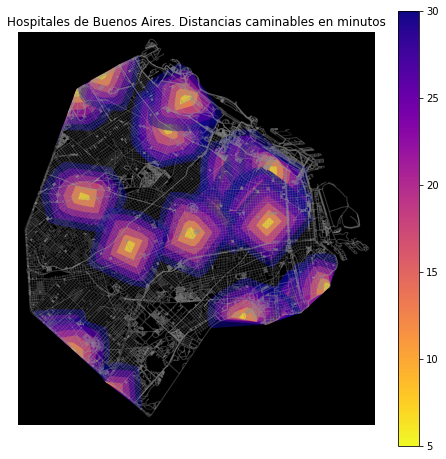

In [ ]:
hospitales_isocronas.plot('contour', ax=ax, alpha=0.6, zorder=-1, legend = True)
plt.title("Hospitales de Buenos Aires. Distancias caminables en minutos")


Algunas isocronas se superponen con otras. Podemos reorganizar el dataframe para que las isocronas se ordenen de forma descendente respecto a su valor de tiempo, lo cual hace que se grafiquen de forma más prolija (la columna "contour" es la que contiene el tiempo de viaje).

<font color="grey"> [English] Some isochrones overlap with others. We can rearrange the dataframe so that the isochrones are ordered in descending order with respect to their time value, which makes them plot more neatly (the "contour" column is the one containing the travel time).

<font color="grey"> [Portugues] Alguns isócrones sobrepõem-se a outros. Podemos reorganizar o quadro de dados de modo a que os isócrones sejam ordenados por ordem decrescente em relação ao seu valor temporal, o que os torna traçados mais ordenados (a coluna "contour" é a que contém o tempo de viagem).

Text(0.5, 1.0, 'Hospitales de Buenos Aires. Distancias caminables en minutos')

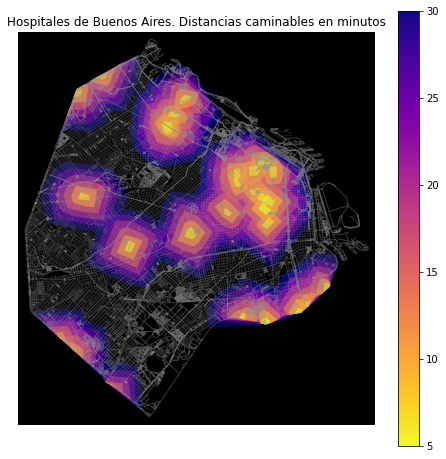

In [ ]:
fig, ax = ox.plot_graph(ba_grilla, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k')

hospitales_isocronas.sort_values(by='contour', ascending=False).plot('contour', ax=ax, alpha=0.6, zorder=-1, cmap="plasma_r", legend = True)
plt.title("Hospitales de Buenos Aires. Distancias caminables en minutos")



Podemos observar que hay zonas de la ciudad no se encuentran abastecidas por la oferta de hospitales.

<font color="grey"> [English] We can observe that there are areas of the city that are not supplied by the supply of hospitals.

<font color="grey"> [Portugues] Pode-se observar que algumas partes da cidade não são servidas pelo fornecimento de hospitais.

### Disponibilidad de farmacias

<font color="grey"> [English] Availability of pharmacies

<font color="grey"> [Portugues] Disponibilidade de farmácias

Queremos evaluar ahora la cantidad de farmacias disponibles cada 10mil habitantes.  
Cabe destacar que OSM es un proyecto colaborativo y que los datos pueden tener sesgos en zonas donde hay poca actividad de la comunidad cargando los datos.

<font color="grey"> [English] We now want to evaluate the number of pharmacies available per 10,000 inhabitants.  
It should be noted that OSM is a collaborative project and the data may be biased in areas where there is little community activity in uploading data.

<font color="grey"> [Portugues] Queremos agora avaliar o número de farmácias disponíveis por 10.000 habitantes.  
É de notar que o OSM é um projecto de colaboração e os dados podem ser tendenciosos em áreas onde há pouca actividade comunitária no carregamento de dados.

In [ ]:
farmacias = es[es['poi_type']== 'pharmacy']

Vamos a evaluar disponibilidad de comercios per capita dentro de nuestros polígonos hexagonales. Para eso, vamos a calcular la cantidad de comercios en cada hexagono.
Incorporamos la variable *cant* para indicar la cantidad de comercios.

<font color="grey"> [English] We are going to evaluate the availability of stores per capita within our hexagonal polygons. For that, we are going to calculate the number of stores in each hexagon.
We incorporate the variable *cant* to indicate the number of stores.

<font color="grey"> [Portugues] Vamos avaliar a disponibilidade de lojas per capita dentro dos nossos polígonos hexagonais. Para isso, vamos calcular o número de lojas em cada hexágono.
Incorporamos a variável *cant* para indicar o número de lojas.

In [ ]:
farmacias['cantidad'] = 1

Vamos a calcular la cantidad de farmacias por hexágono.

<font color="grey"> [English] Let's calculate the number of pharmacies per hexagon.

<font color="grey"> [Portugues] Vamos calcular o número de farmácias por hexágono.

In [ ]:
hex_ba_farmacias = up.geom.merge_shape_hex(hex_ba, farmacias, agg={'cantidad':'sum'})

Graficamos

<font color="grey"> [English] We plot.

<font color="grey"> [Portugues] Traçamos

<AxesSubplot:>

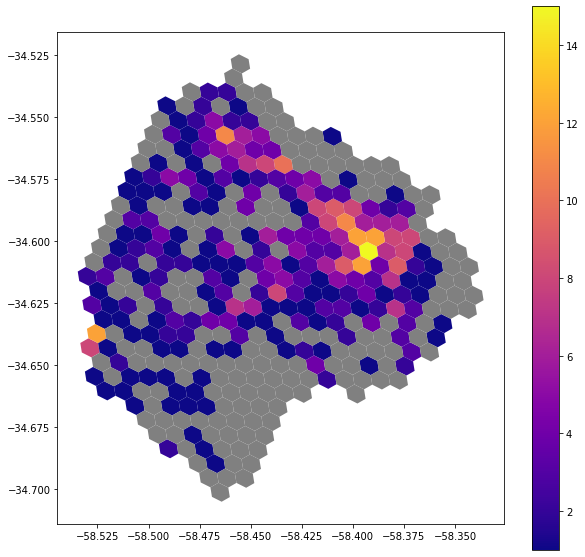

In [ ]:
hex_ba_farmacias.plot('cantidad', legend=True, missing_kwds={'color':'grey'}, cmap="plasma")


Remplazamos los valores nulos por 0: en esa celda no se encontraron farmacias.

<font color="grey"> [English] We replace null values by 0: no pharmacies were found in that cell.

<font color="grey"> [Portugues] Substituímos os valores nulos por 0: não foram encontradas farmácias nessa célula.

In [ ]:
hex_ba_farmacias['cantidad'] = hex_ba_farmacias['cantidad'].fillna(0)

Vamos a generar un indicador de ratio de farmacias per capita cada 10.000 habitantes (considerando la población de 2020).

<font color="grey"> [English] We will generate an indicator of the ratio of pharmacies per capita per 10,000 inhabitants (considering the 2020 population.

<font color="grey"> [Portugues] Vamos gerar um indicador do rácio de farmácias per capita por 10.000 habitantes (considerando a população de 2020).

In [ ]:
hex_ba_farmacias['r_farmacia'] = round(hex_ba_farmacias['cantidad'] *10000 / hex_ba_farmacias['population_2020'], 4)

In [ ]:
hex_ba_farmacias.head()

hex  population_2020        lat        lon  hosp_cercano  \
0  88c2e31283fffff      6895.882444 -34.620294 -58.506940             5   
1  88c2e310e1fffff      7569.948647 -34.597763 -58.459001            16   
2  88c2e311c9fffff     14688.895738 -34.609642 -58.421776             4   
3  88c2e31047fffff     10240.603225 -34.638255 -58.438006            16   
4  88c2e31211fffff      5059.313199 -34.655053 -58.482713            17   

   distancia_a_hosp  duracion_a_hosp  \
0            3.1421        37.706667   
1            3.3607        40.686667   
2            0.4669         5.736667   
3            2.5434        31.118333   
4            3.9466        47.681667   

                                            geometry  cantidad  r_farmacia  
0  POLYGON ((-58.50619 -34.62414, -58.50220 -34.6...       0.0      0.0000  
1  POLYGON ((-58.45825 -34.60161, -58.45426 -34.5...       0.0      0.0000  
2  POLYGON ((-58.42103 -34.61349, -58.41703 -34.6...       3.0      2.0424  
3  POLYGON ((-58.43726 -34.64210, -58.43326 -34.6...       1.0      0.9765  
4  POLYGON ((-58.48196 -34.65889, -58.47797 -34.6...       0.0      0.0000

Graficamos

<font color="grey"> [English] We plot.

<font color="grey"> [Portugues] Traçamos

Text(0.5, 1.0, 'Ciudad de Buenos Aires, Argentina. Cantidad de farmacias cada 10000 hab')

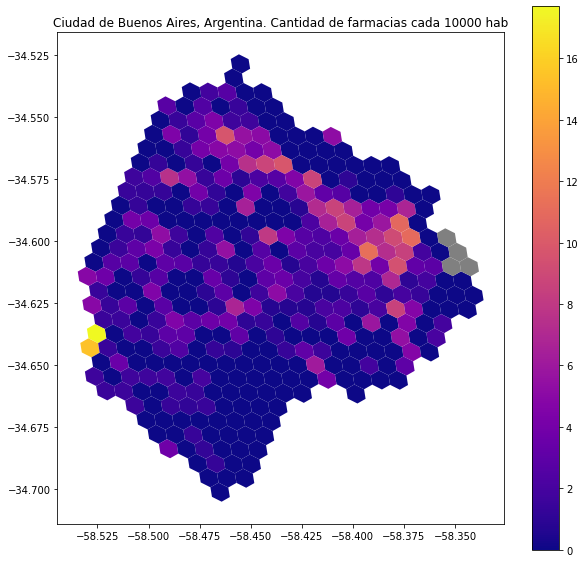

In [ ]:
hex_ba_farmacias.plot('r_farmacia', legend=True, missing_kwds={'color':'grey'}, cmap = "plasma")
plt.title(ciudad + '. Cantidad de farmacias cada 10000 hab')

Realizamos ahora un mapa interactivo.

<font color="grey"> [English] We will make an interactive map.

<font color="grey"> [Portugues] Fazemos agora um mapa interactivo.

In [ ]:
fig = up.plotting.choropleth_map(hex_ba_farmacias, 'r_farmacia', title=ciudad + '. Tasa de Farmacias',
                                 zoom = 10, color_continuous_scale="Plasma",
                                 opacity=0.8,
                                 labels={'r_farmacia':'Farmacias c/10000hab'}

                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()

Si bien hay zonas donde el indicador bajo corresponde a vacíos urbanos, es posible que en la zona sur de la ciudad la base de OSM no cuente con todas las farmacias que realmente existen en esa zona.

<font color="grey"> [English] While there are areas where the low indicator corresponds to urban voids, it is possible that in the southern part of the city the OSM base does not count all the pharmacies that actually exist in that area.

<font color="grey"> [Portugues] Embora existam áreas onde o indicador baixo corresponde a vazios urbanos, é possível que na parte sul da cidade a base OSM não conte todas as farmácias que realmente existem nessa área.